# Estimating the number of Bikeshare rides in DC based on weather and time data, with Linear regression and Random Forest

In this projekt I wanted to explore the effects that Weather has on bike lending data. Especially because DC is an urban area whgere many people use those bikes to get to and from work. The results may efffect how we look at climate affect to biking i.e. "You don't have to have bike rentals here the weather is too bad" may not be a reasonable esquse based on data.

The data was extracted from the Capitalbikeshare website: https://s3.amazonaws.com/capitalbikeshare-data/index.html and the weather Data was extracted from Open-Meteo.com with these Coordinates.

# Data
The extraced data is comprised of 3 differend types of tabulated data.
Combined the Data is about 4.5 GB large
1. The Weather Data wich is tabulated and has 13 Features, every freature exept time is numeric, the time feature is of the datatype datetime | contains 184.104 rows
2. The biking data until 2020/03 there are 9 Features, 1 numeric, 2 Datetime, and 6 categorical | Contains about 200.000 rows per csv
3. The biking data after 2020/05 there are 13 Features, 4 numeric, 2 Datetime, and 7 categorical | Contains about 420.000 rows per csv

# Data cleaning
To make this Dataset estimate the number of Rides per hour I needed to change the Dataset to resemble that, starting out I only had one entry per ride and the Start time.

In the process of doing that I combined every bikeshare csv to one large one for later analysis.

In [ ]:
import pandas as pd
import os
import glob

data_folder = ''  # Folder Path deleted for privacy

# Get list of all CSV files in the folder
csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

dataframes = []

for file in csv_files:
    df = pd.read_csv(file)
    # Determine if file is in old or new format
    if 'Duration' in df.columns:
        # Old format, no need to process
        dataframes.append(df)
    else:
        # New format, process to match old format
        # Remove unnecessary columns (if they exist)
        columns_to_drop = ['ride_id', 'rideable_type', 'start_lat', 'start_lng', 'end_lat', 'end_lng']
        df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

        # Calculate Duration
        df_cleaned['Duration'] = (
            pd.to_datetime(df_cleaned['ended_at']) - pd.to_datetime(df_cleaned['started_at'])
        ).dt.total_seconds().astype(int)

        # Rename columns to match old format
        df_cleaned.rename(columns={
            'started_at': 'Start date',
            'ended_at': 'End date',
            'start_station_name': 'Start station',
            'end_station_name': 'End station',
            'start_station_id': 'Start station number',
            'end_station_id': 'End station number',
            'member_casual': 'Member type'
        }, inplace=True)

        # Append the cleaned dataframe
        dataframes.append(df_cleaned)

# Concatenate all dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

# Optional: Reorder columns if necessary
desired_column_order = [
    'Duration', 'Start date', 'End date', 'Start station number', 'Start station',
    'End station number', 'End station', 'Bike number', 'Member type'
]
# Adjust the list above based on the columns present in your data
combined_df = combined_df[[col for col in desired_column_order if col in combined_df.columns]]

# Save combined dataframe to a CSV file
combined_df.to_csv('', index=False) #path removed for privacy 


ValueError: No objects to concatenate

After Combining ever ride to one csv I then grouped them Hourly to be able to make predictions on bike usage and not only have 1 row per Bike

In [ ]:
import pandas as pd
import os
import glob

input_file = '' #removed for privacy

df_full = pd.read_csv(input_file)

# Convert 'Start date' to datetime
df_full['Start date'] = pd.to_datetime(df_full['Start date'])

# Create a new column for the time block, which rounds down to the nearest hour
df_full['Time block'] = df_full['Start date'].dt.floor('H')

# Group by the time block and calculate the average duration and number of rides per block
grouped_full = df_full.groupby('Time block').agg(
    Average_duration=('Duration', 'mean'),
    Number_of_rides=('Duration', 'size')
).reset_index()

# Create a range of hourly time blocks covering the span of the data
full_time_range_full = pd.date_range(start=df_full['Time block'].min(), end=df_full['Time block'].max(), freq='H')

# Merge the grouped data with the full time range to fill in any missing hours
full_data_full = pd.DataFrame(full_time_range_full, columns=['Time block']).merge(
    grouped_full, on='Time block', how='left'
)

# Fill missing values for Number_of_rides with 0 and for Average_duration with NA (or NaN in pandas)
full_data_full['Number_of_rides'].fillna(0, inplace=True)
full_data_full['Average_duration'].fillna('NA', inplace=True)

# Save the new data to a CSV
output_file_full ='' #removed for privacy
full_data_full.to_csv(output_file_full, index=False)

output_file_full


I then combined the Weather and the rides Table to finaly have one large CSV

In [ ]:
import pandas as pd

weather_df = pd.read_csv('', low_memory=False) #removed for privacy

# Parse the time column, specifying the correct format
weather_df['time'] = pd.to_datetime(weather_df['time'], format='%Y-%m-%dT%H:%M', errors='coerce')

# Check if any rows have invalid time values (they will be marked as NaT)
invalid_times = weather_df[weather_df['time'].isna()]
if not invalid_times.empty:
    print("Rows with invalid time format:")
    print(invalid_times)

# MERGE
rides_df = pd.read_csv('') #removed for privacy

# Convert the 'Time block' column in the rides dataset to datetime
rides_df['Time block'] = pd.to_datetime(rides_df['Time block'])

# Merge the two datasets on the time block
merged_df = pd.merge(rides_df, weather_df, left_on='Time block', right_on='time', how='inner')

# Drop the extra 'time' column from the merged DataFrame (if needed)
merged_df.drop('time', axis=1, inplace=True)

# Save the merged data to a new CSV
output_file = 'merged_rides_weather_limited.csv'#can stay
merged_df.to_csv(output_file, index=False)

print(f"Combined data saved to {output_file}")

# Data cleaning

The following data cleaning steps were performed



1.   Dropped rows that wern't needed (ride_id, rideable_type, start_lat, start_lng, end_lat, and_lng)
2.   Used started_at and ended_at to calculate average duration.
3.  Renamed colums to match the other dataset.
4.  Combined the rides data to a single dataset
5.  Converted the Start date to Time block by rounding down to the nearest hour, and combined the rides (added number of ride, and average duration)
6.  Merging the rides data with the weather data with the time features.


There was no further need to clean the dataset, as bike data is by desing voluntile.


#EDA
histogram, correlation matrix, feature importance

With the EDA I want to explore the significance of the freatures compared to the number of rides per hour.
I will test if weather has an effect and if every feature is indipendent enough from each other to prevent overfitting one feature.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('merged_rides_weather_limited.csv')


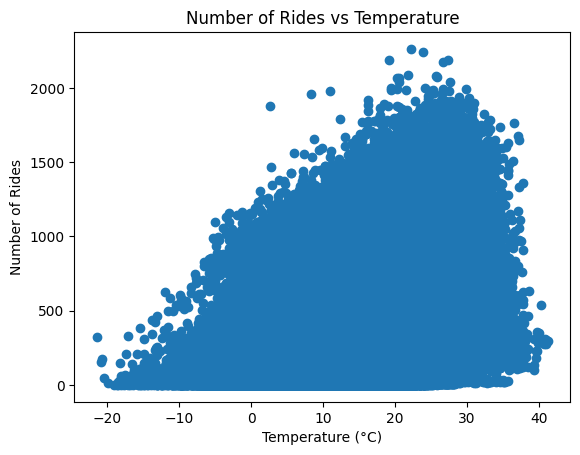

In [1]:
plt.scatter(df['temperature_2m (°C)'], df['Number_of_rides'])
plt.title('Number of Rides vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Rides')
plt.show()

As you can see with temperature rising (until arround 35°C) there is a increase in number of rides overall. This indicates a corrolation between rides and temperatures. But there are still many hours even when its warmer where not many people ride those bikes

In [6]:
from scipy import stats

corr_pearson, p_val = stats.pearsonr(df['temperature_2m (°C)'], df['Number_of_rides'])

corr_pearson, p_val

(np.float64(0.42964249725702947), np.float64(0.0))

A P-value of 0 indicates that the corolation is statisticly significant
With a correlation coeficcient of 0.43 positively corollated

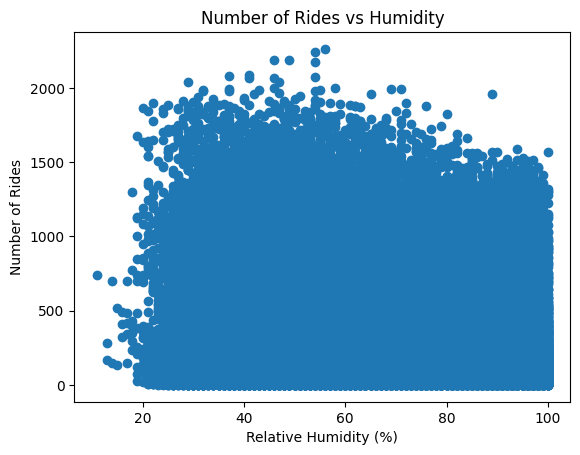

In [7]:
plt.scatter(df['relative_humidity_2m (%)'], df['Number_of_rides'])
plt.title('Number of Rides vs Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Number of Rides')
plt.show()


As you can see there is a slight decrease in the number of rides with higher Humidity, this indicated a negative corrolation

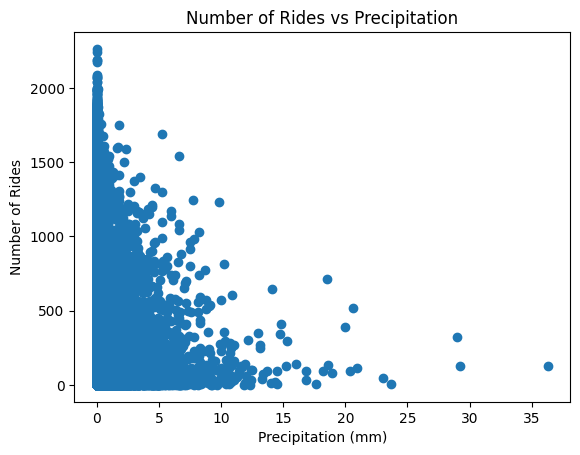

In [ ]:
plt.scatter(df['precipitation (mm)'], df['Number_of_rides'])
plt.title('Number of Rides vs Precipitation')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Number of Rides')
plt.show()

As you can see with more Precipitation the number of rides goes down, this also indicates a negative corolation

In [ ]:
from scipy import stats

# Group rides by rain (precipitation > 0 means rainy, == 0 means sunny)
rainy = df[df['precipitation (mm)'] > 0]['Number_of_rides']
sunny = df[df['precipitation (mm)'] == 0]['Number_of_rides']

# Perform t-test to check if there is a significant difference in number of rides between rainy and sunny days
t_stat, p_value = stats.ttest_ind(rainy, sunny)

t_stat, p_value

(np.float64(-29.182782453479582), np.float64(1.5167445865116762e-186))

In the statistical analysis you can see that the P-vlue is small that indicated that the correlation is significant, the corrolation coefficient of -29.18 indicates a negetive corollation

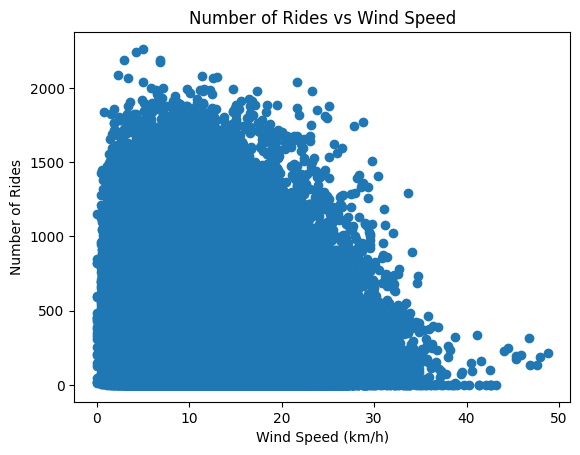

In [ ]:
plt.scatter(df['wind_speed_10m (km/h)'], df['Number_of_rides'])
plt.title('Number of Rides vs Wind Speed')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Number of Rides')
plt.show()

As you can see as the wind speed goes up the number of rides goes down, this also indicates a negative corrolation

# Correlation Matrix

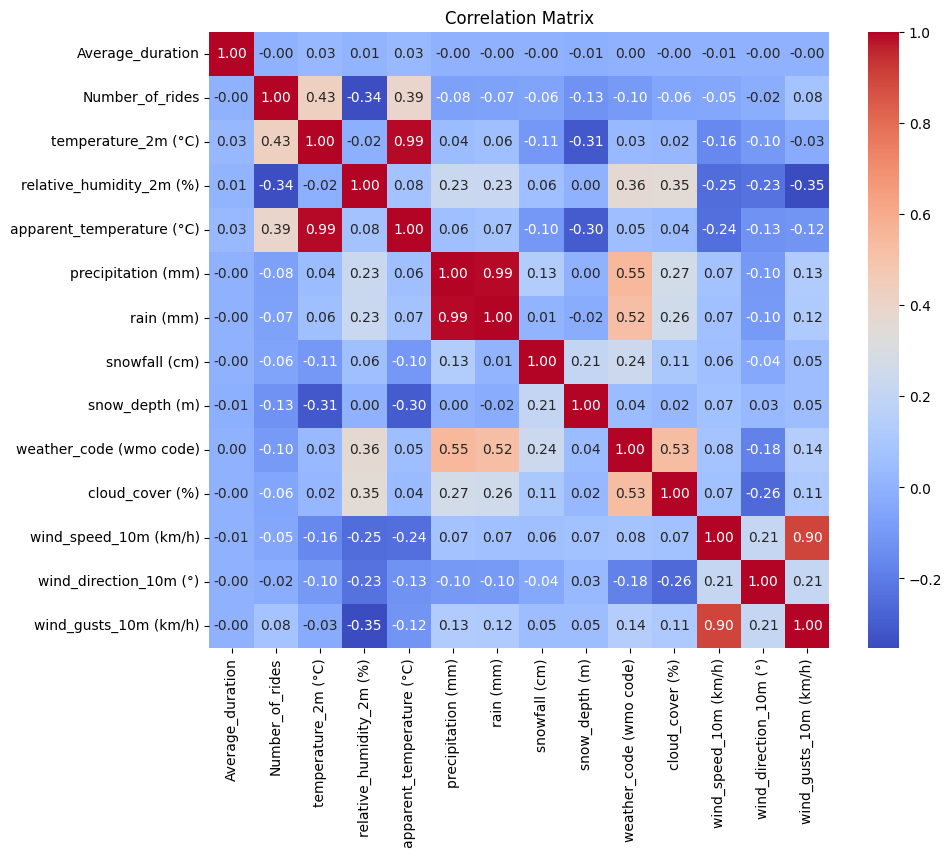

In [ ]:
import seaborn as sns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

As you can see in the Corrolation Matrix average duration of rides has no impact and will be disregared from now on.

Furthermore multiple weather features are highly corrolated with each other like temperature and apparent temperature, rain and precipitation, or wind and wind gusts this could be a problem further on.

Temperature has the highest corrolation with number of rides, this indicates that the temperature will be a strong feature.

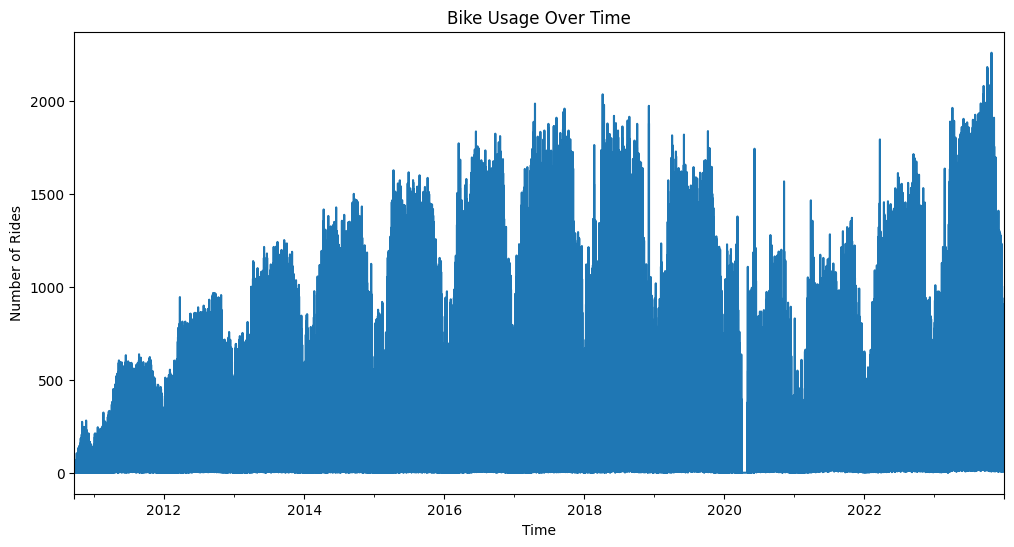

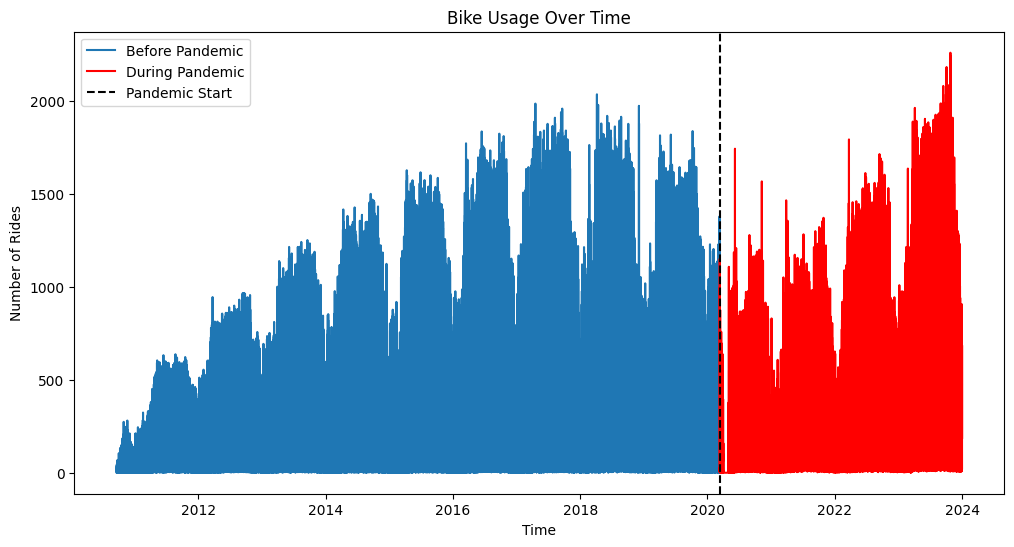

In [12]:
df.set_index('Time block')['Number_of_rides'].plot(figsize=(12, 6))
plt.title('Bike Usage Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Rides')
plt.show()

import matplotlib.pyplot as plt
import pandas as pd

df_pandemic = df.copy()

# Set 'Time block' as the index
df_pandemic.set_index('Time block', inplace=True)


pandemic_start_date = pd.to_datetime('2020-03-11')  # WHO declared COVID-19 a pandemic on March 11, 2020

# Split the data into before and after the pandemic start date
df_before = df_pandemic[df_pandemic.index < pandemic_start_date]
df_after = df_pandemic[df_pandemic.index >= pandemic_start_date]


plt.figure(figsize=(12, 6))
# Plot data before the pandemic
plt.plot(df_before.index, df_before['Number_of_rides'], label='Before Pandemic')

# Plot data during the pandemic in red
plt.plot(df_after.index, df_after['Number_of_rides'], color='red', label='During Pandemic')

# Add a vertical line to mark the pandemic start date
plt.axvline(pandemic_start_date, color='black', linestyle='--', label='Pandemic Start')

plt.title('Bike Usage Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Rides')
plt.legend()
plt.show()

The start of the red section stands for the beginning of the cov-19 pandemic.
You can see with the naked eye that this data falls out of line for at least two years after the start of the pandemic with the rest of the data.

Therefore the Data of 2020/03 to 2022/03 will not be used later in the algorithm.

As you can see Time is a important variable when it comes to rides, so I will **add Year Month Day of the Month features**.

In [13]:
df['Time block'] = pd.to_datetime(df['Time block'])

# Adding 'Year', 'Month', and 'Day' to the DataFrame
df['Year'] = df['Time block'].dt.year
df['Month'] = df['Time block'].dt.month
df['Day'] = df['Time block'].dt.dayofweek
df['Hour'] = df['Time block'].dt.hour
df['Day1'] = df['Time block'].dt.day

# Linear Regression
First lets run a Linear Regression algorithm, and output the VIF (Variance Inflation Factor) and the MSE (Mean squared Error)


In [14]:
# Import necessary libraries for Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np


# Select features and target for the regression
features = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'apparent_temperature (°C)',
                    'precipitation (mm)', 'rain (mm)', 'snowfall (cm)', 'snow_depth (m)',
                    'weather_code (wmo code)', 'cloud_cover (%)', 'wind_speed_10m (km/h)',
                    'wind_direction_10m (°)', 'wind_gusts_10m (km/h)', 'Year', 'Month', 'Day', 'Hour']

X = df[features]  
y = df['Number_of_rides']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model and fit it to the training data
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_reg_model.predict(X_test)

# Calculate and display the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Multicollinearity check using Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

vif_data  # Displaying VIF values for each feature


Mean Squared Error: 70959.493885157


,Feature,VIF
0,temperature_2m (°C),686.453368
1,relative_humidity_2m (%),43.172125
2,apparent_temperature (°C),478.887092
3,precipitation (mm),45270.383023
4,rain (mm),44422.466239
5,snowfall (cm),659.946910
6,snow_depth (m),1.263000
7,weather_code (wmo code),2.536701
8,cloud_cover (%),3.570351
9,wind_speed_10m (km/h),35.183203


## Results
Precipitation, rain, temperature, and apparent temperature have a very high VIF wich could effect the MSE negetivly.

Furthermore the very high MSE of 70959 indicates that this model might not be the best to predict the number of rides.


Linear Regession without apparent_temperature and precipitaion


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np


features = ['temperature_2m (°C)', 'rain (mm)', 'relative_humidity_2m (%)', 'snowfall (cm)', 'snow_depth (m)',
                    'weather_code (wmo code)', 'cloud_cover (%)', 'wind_speed_10m (km/h)',
                    'wind_direction_10m (°)','Year', 'Month', 'Day','Hour']

X = df[features] 
y = df['Number_of_rides']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Predict 
y_pred = linear_reg_model.predict(X_test)

# Calculate and display the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

vif_data  # Displaying VIF values for each feature


Mean Squared Error: 72910.11861555935


,Feature,VIF
0,temperature_2m (°C),3.618229
1,rain (mm),1.468673
2,relative_humidity_2m (%),21.300361
3,snowfall (cm),1.144187
4,snow_depth (m),1.238154
5,weather_code (wmo code),2.419906
6,cloud_cover (%),3.462043
7,wind_speed_10m (km/h),5.699626
8,wind_direction_10m (°),6.323427
9,Year,50.151803


## Results
Even with apparent_temperature and precipitaion eliminated the MSE is still very high with a value of 72910.

There are still higher VIFs but I wont fine tune the Linear regession model any further, the high MSE indicates that another model might be more accurate and the dependency isn't linear

# Random Forest
Let's run the Random Forest algorithm on the entire dataset, without pruning or anything else.

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Calculate and display the Mean Squared Error (MSE) for the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf}")


Mean Squared Error (Random Forest): 8559.621142765107


## Results
The MSE of 8559 indicates that this model works way better lan the linear regression model for this dataset.


## Fine tune the Model
After talkting to some Data analysts they indicated that the Cov-19 Pandemic might ruin my algorithm. So I looked at the histogram in the exporitory part and came to the conclusion to try and run the Random Forest algorithm without a 2 Year Covid span.
This might better the performance of the model significantly.


In [22]:
# Filter data based on Year and Month to exclude March 2020 to March 2022
df_filtered = df[~((df['Year'] == 2020) & (df['Month'] >= 3)) & ~((df['Year'] == 2021)) & ~((df['Year'] == 2022) & (df['Month'] <= 3))]


features_full = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'apparent_temperature (°C)',
                 'precipitation (mm)', 'rain (mm)', 'snowfall (cm)', 'snow_depth (m)', 'weather_code (wmo code)',
                 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)', 'wind_gusts_10m (km/h)',
                 'Year', 'Month', 'Day', 'Hour']
X = df_filtered[features_full]  
y = df_filtered['Number_of_rides']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Create and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

#Predict
y_pred_rf = rf_model.predict(X_test)

#Calculate and display the Mean Squared Error (MSE) for the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf}")

Mean Squared Error (Random Forest): 8409.658758922567


As you can see eliminating the rideshare data heavily impacted by the Pandamic the Performance increased

The Time features had a very high feature importance so I added another one "Day1" wich tells the day of the week

In [23]:
df_filtered = df[~((df['Year'] == 2020) & (df['Month'] >= 3)) & ~((df['Year'] == 2021)) & ~((df['Year'] == 2022) & (df['Month'] <= 3))]

features_full = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'apparent_temperature (°C)',
                 'precipitation (mm)', 'rain (mm)', 'snowfall (cm)', 'snow_depth (m)', 'weather_code (wmo code)',
                 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)', 'wind_gusts_10m (km/h)',
                 'Year', 'Month', 'Day', 'Hour', 'Day1']
X = df_filtered[features_full] 
y = df_filtered['Number_of_rides']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Create and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

#Predict
y_pred_rf = rf_model.predict(X_test)

#Calculate and display the Mean Squared Error (MSE) for the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf}")

Mean Squared Error (Random Forest): 7801.563041146205


## Results
As you can see adding the Day of the week feature further improves the model

Next I want to compare it with a model with less features, so I used the most significant ones

In [ ]:
df_filtered = df[~((df['Year'] == 2020) & (df['Month'] >= 3)) & ~((df['Year'] == 2021)) & ~((df['Year'] == 2022) & (df['Month'] <= 3))]

features_full = ['temperature_2m (°C)', 'relative_humidity_2m (%)',
                     'precipitation (mm)', 'wind_speed_10m (km/h)', 'cloud_cover (%)',
                     'Hour', 'Day', 'Month', 'Year']
X = df_filtered[features_full]  # Use the relevant features
y = df_filtered['Number_of_rides']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#Create and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

#Predict
y_pred_rf = rf_model.predict(X_test)

#Calculate and display the Mean Squared Error (MSE) for the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf}")

Mean Squared Error (Random Forest): 8532.722716465445


## Results
As you can see the accuracy has decreased.
But there was a slight increase in the compute Time

**Next generate more data for the 2 final algorithms**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#Calculate the Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)

#Calculate Root Mean Squared Error (RMSE)
rmse_rf = np.sqrt(mse_rf)

#Calculate Mean Absolute Error (MAE)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

#Calculate R-squared (R^2)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Mean Squared Error (MSE) - Random Forest: {mse_rf}")
print(f"Root Mean Squared Error (RMSE) - Random Forest: {rmse_rf}")
print(f"Mean Absolute Error (MAE) - Random Forest: {mae_rf}")
print(f"R-squared (R²) - Random Forest: {r2_rf}")

Mean Squared Error (MSE) - Random Forest: 7801.563041146205
Root Mean Squared Error (RMSE) - Random Forest: 88.3264571979778
Mean Absolute Error (MAE) - Random Forest: 48.61200135846493
R-squared (R²) - Random Forest: 0.9371930977052663


## Model performance

Mean Squared Error (MSE) - Random Forest: 7801.563041146205
Root Mean Squared Error (RMSE) - Random Forest: 88.3264571979778
Mean Absolute Error (MAE) - Random Forest: 48.61200135846493
R-squared (R²) - Random Forest: 0.9371930977052663

These are the Performance results of the feature rich Random Forest algorithm. With a high R^2 and low MSEn (in relation to the number of rides) the model is significant and can estimate the number of rides per hour.

#### Compared with Linear Regression

Compared with linear regression the model outperformes it by a mile even without feature selection the difference was significant with the MSE (see above)

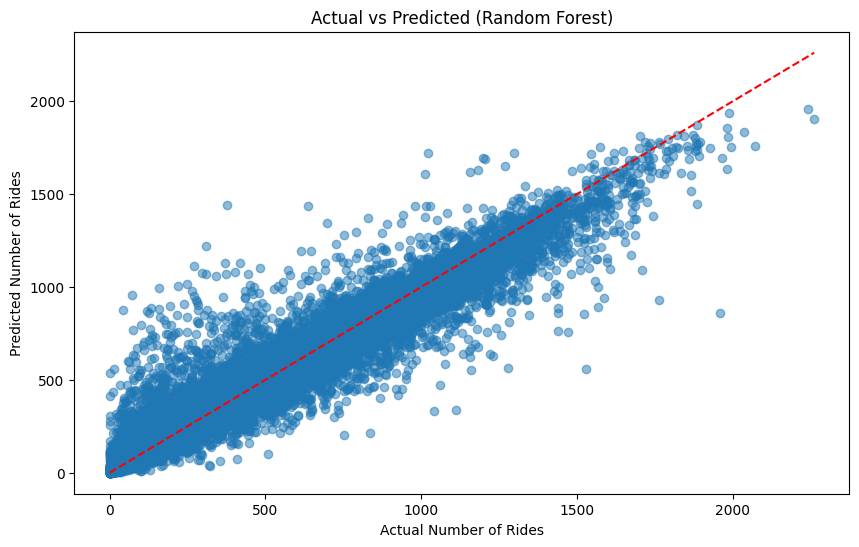

In [ ]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.xlabel('Actual Number of Rides')
plt.ylabel('Predicted Number of Rides')
plt.title('Actual vs Predicted (Random Forest)')
plt.show()

### Actual vs Predicted
At arround 0 - 700 rides the model predicts the number of rides on average higher, with more rides per hour the model tends to underestimates the number of rides.

The red line indicates when Prediction is equal to the actual number of rides.

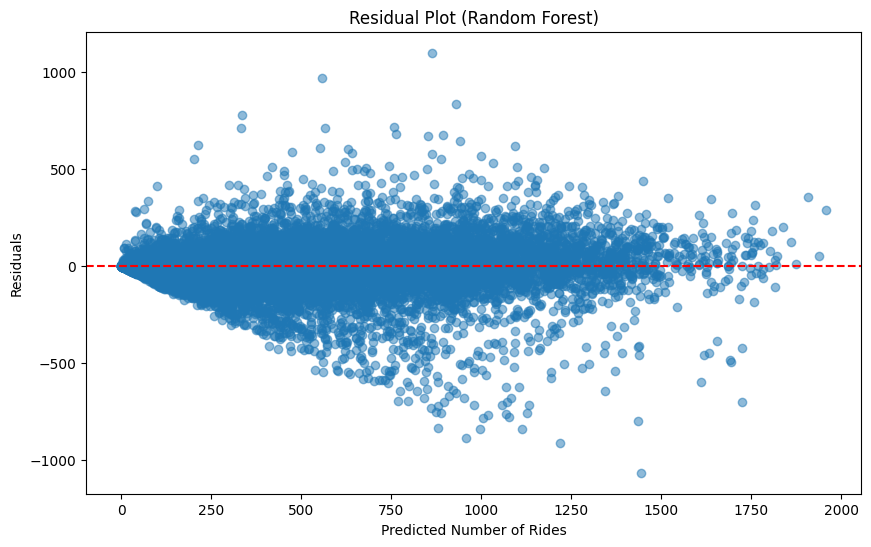

In [ ]:
residuals = y_test - y_pred_rf

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Number of Rides')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest)')
plt.show()

In [ ]:
print(df_filtered.columns)

print(df_filtered.head())

Index(['Time block', 'Average_duration', 'Number_of_rides',
       'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'snowfall (cm)', 'snow_depth (m)', 'weather_code (wmo code)',
       'cloud_cover (%)', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)',
       'wind_gusts_10m (km/h)', 'Year', 'Month', 'Day', 'Hour', 'Day1',
       'Date'],
      dtype='object')
           Time block  Average_duration  Number_of_rides  temperature_2m (°C)  \
0 2010-09-20 11:00:00        536.500000              2.0                 21.6   
1 2010-09-20 12:00:00       1253.941176             17.0                 23.1   
2 2010-09-20 13:00:00        836.272727             11.0                 24.3   
3 2010-09-20 14:00:00       1279.166667              6.0                 25.1   
4 2010-09-20 15:00:00       1771.250000             12.0                 25.4   

   relative_humidity_2m (%)  apparent_temperature (°C)  precipitatio

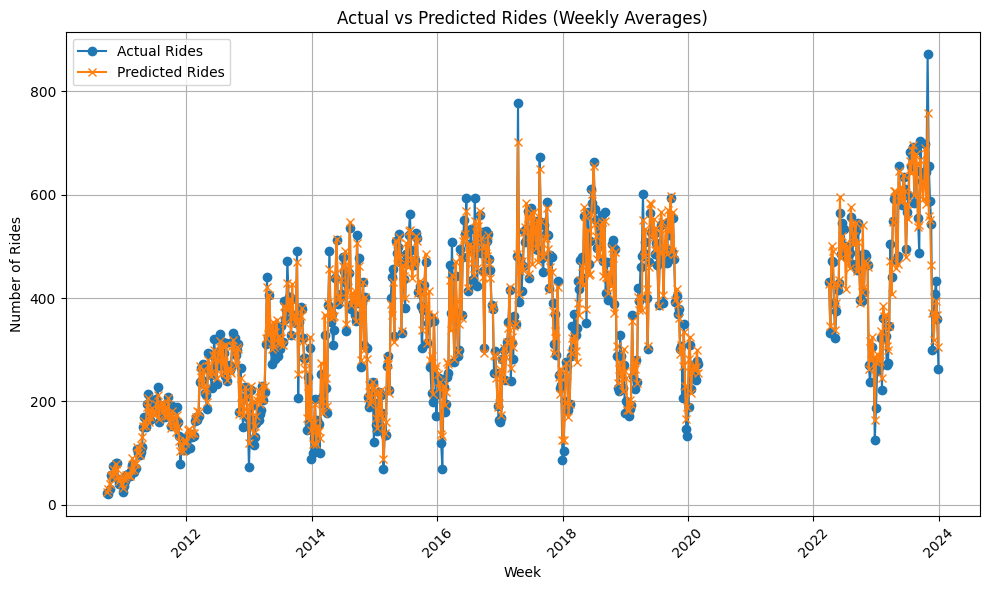

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Combine y_test and y_pred_rf into a DataFrame and align with Time block
y_test_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf}, index=y_test.index)
df_filtered_test = df_filtered.loc[y_test.index].copy()  # Get corresponding rows from df_filtered
df_filtered_test = df_filtered_test.join(y_test_df)  # Add actual and predicted values

#Resample to get weekly averages
weekly_data = df_filtered_test.resample('W', on='Time block').agg({
    'Actual': 'mean',
    'Predicted': 'mean'
})

#Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.plot(weekly_data.index, weekly_data['Actual'], label='Actual Rides', marker='o')
plt.plot(weekly_data.index, weekly_data['Predicted'], label='Predicted Rides', marker='x')

plt.title('Actual vs Predicted Rides (Weekly Averages)')
plt.xlabel('Week')
plt.ylabel('Number of Rides')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This plot shows the actual rides and the predicted rides averaged per week. As you can see the predicted and actual rides follow each other very congruently

# Results summary

The model performance was good with
Mean Squared Error (MSE) - Random Forest: 7801.563041146205
R-squared (R²) - Random Forest: 0.9371930977052663

With lower actual bike usage the model tends to overestimate and with larger usage the model tends to underestimate the number of bikes in use.

There are some outliars in the data where the model had problems with estimating the number of rides and overestimated by > 1000 but this was not a regular accourance.

The model works reasonably well at estimating the number of rides per hour with weather data.

With further data like events or holidays the accuracy could be improved.


And even tough weather has an impact on the number of rides, it is by far not the only important feature, and many people bike in the rain or snow

# Learning and takeaways

In the process of making this project I learned the importance of Data cleaning and how it can seriosly impact the model performance.
After "cleaning" the Cov-19 data i.e. not using it my models performance increased higher than I enticipated.

Furthermore I underestimated the time to get a dataset that I was interested in.


# Discussion of why something didn't work

Somehow the results for the Random forest algorithm were in the 20000MSE for a long time but suddenly they dropped to 8k, I think I broke something in my dataset trying to reduse the MSE and dind't realise it. That combined with the ammount of time it took to compute each model this costs a lot of time

# Suggest ways to improve

To improve the estimation results there is the need for more data like holidays, memorials or events. There are reasons for bike usage spiked that can not be explained with weather and time data alone, but that was expected.